In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

In [2]:
def collect_data_and_plot(df, test_mode, setting_name, underage_cost):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'],
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/one_warehouse_real/{row['# of stores']}/{row['Architecture Class']}/{underage_cost}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 24:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_cost = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        n_samples = 32768
        batch_size = 4096
        num_batches = n_samples // batch_size
        num_steps = 500
        start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        n_stores = row['# of stores']
        avg_s_underage.append(relevant_data['s_underage_costs'].mean() / underage_cost)
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / underage_cost)
        avg_w_holding.append(relevant_data['w_holding_costs'].mean() / underage_cost)
        avg_cost.append(relevant_data['s_underage_costs'].sum() * n_stores + relevant_data['s_holding_costs'].sum() * n_stores + relevant_data['w_holding_costs'].sum())

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding 
    df_copy['avg_cost'] = avg_cost
    df = df_copy

    # Calculate relative cost
    # Calculate cost as percentage of lowest cost
    # Calculate min cost for each number of stores
    df['cost'] = df.groupby('# of stores')['avg_cost'].transform(lambda x: x/x.min() * 100)

    plot_data = df.pivot(index="# of stores", columns='Architecture Class', 
                         values=['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Cost (% of minimum at each # of stores)', 'Average Store lost sales / (average unit underage cost)', 'Average Store Holding Cost / (average unit underage cost)', 'Average Warehouse Holding Cost / (average unit underage cost)']
    y_values = ['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    x_values = df['# of stores'].unique()
    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Just_In_Time':
                continue
            if arch in plot_data[y_value].columns:
                ax.plot(x_values, plot_data[y_value][arch].loc[x_values], marker='o', label=f'{arch}', 
                        color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_xlabel('Number of stores')
        ax.set_ylabel(f'{title}')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_values)
    
    plt.tight_layout()
    plt.show()
    return df


   # of stores Architecture Class  Train Loss  Dev Loss  Test Loss  Test Gap %  # of runs
0            3   Decentralized_WC    6.556189  6.558406   6.555975    0.562112         12
0            3     Symmetry_Aware    6.519452  6.522840   6.520960    0.025006         12
0            3            Vanilla    6.527577  6.523727   6.522144    0.043170         12
0            3                GNN    6.520135  6.521608   6.519329    0.000000         12
1           10   Decentralized_WC    9.036627  9.039249   9.034177    0.655485         12
1           10     Symmetry_Aware    8.977095  8.984747   8.980240    0.054534         12
1           10            Vanilla    8.986204  9.000512   8.995410    0.223556         12
1           10                GNN    8.971963  8.980045   8.975345    0.000000         12
2           50   Decentralized_WC    6.774798  6.777590   6.772760    1.075576         12
2           50     Symmetry_Aware    6.704767  6.711200   6.706597    0.088163         12
2         

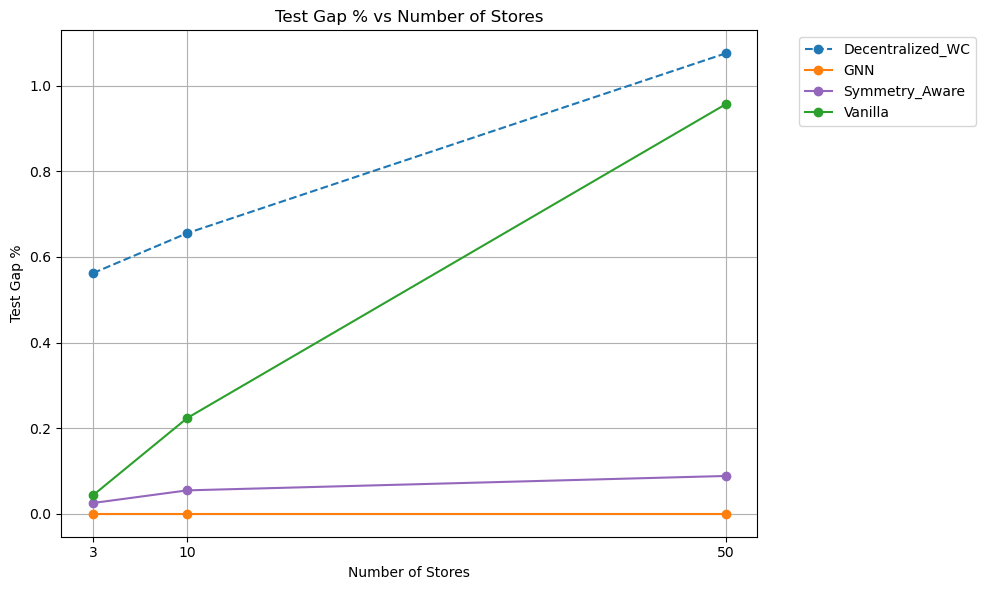

In [3]:
# Define color scheme for architecture types
color_scheme = {
    "Decentralized": "#1f77b4",  # Blue
    "Decentralized_WC": "#1f77b4",  # Blue
    "Symmetry_Aware": "#9467bd",  # Purple
    "Vanilla": "#2ca02c",  # Green
    "GNN": "#ff7f0e",  # Orange
}

linestyle_scheme = {
    "Decentralized": "-",  # Solid
    "Decentralized_WC": "--",  # Dashed
    "Symmetry_Aware": "-",  # Solid
    "Vanilla": "-",  # Solid
    "GNN": "-",  # Solid
}

path = 'warehouse_varying_underage_cost_random_yield'
decentralized_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized/10',
    50: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized/50'
}
vanilla_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla/10',
    50: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla/50'
}
symmetry_aware_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{path}/symmetry_aware/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/symmetry_aware/10',
    50: f'/user/ml4723/Prj/NIC/ray_results/{path}/symmetry_aware/50'
}
gnn_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN/10',
    50: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN/50'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'store_orders_for_warehouse':
        return False
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'test_loss'

results_interpretor = rri.RayResultsinterpreter()

# Basic Decentralized
df_decentralized = results_interpretor.make_table(decentralized_paths,
    {'store_orders_for_warehouse': False},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_decentralized.insert(2, 'Architecture Class', "Decentralized")
df_decentralized.insert(1, 'hyperparam_name', "decentralized")

# Decentralized without context
df_decentralized_wc = results_interpretor.make_table(symmetry_aware_paths,
    {'store_orders_for_warehouse': False, 'omit_context_from_store_input': True},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_decentralized_wc.insert(2, 'Architecture Class', "Decentralized_WC")
df_decentralized_wc.insert(1, 'hyperparam_name', "symmetry_aware")

# Basic Symmetry aware
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths,
    {'store_orders_for_warehouse': False, 'omit_context_from_store_input': False},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware.insert(2, 'Architecture Class', "Symmetry_Aware")
df_symmetry_aware.insert(1, 'hyperparam_name', "symmetry_aware")

# Vanilla
df_vanilla = results_interpretor.make_table(vanilla_paths,
    {},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(2, 'Architecture Class', "Vanilla")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_one_warehouse")

# GNN
df_gnn = results_interpretor.make_table(gnn_paths,
    {},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.insert(2, 'Architecture Class', "GNN")
df_gnn.insert(1, 'hyperparam_name', "GNN")

# Combine dataframes
df = pd.concat([
    # df_decentralized,
    df_decentralized_wc,
    df_symmetry_aware,
    df_vanilla,
    df_gnn
])

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
# Move '# of runs' column to the end
if '# of runs' in df.columns:
    runs_col = df.pop('# of runs')
    df['# of runs'] = runs_col

df_to_print = df.copy()
columns_to_drop = ['path', 'Learning Rate', 'include_context_for_warehouse_input', 'hyperparam_name', 'store_orders_for_warehouse', 'omit_context_from_store_input']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create pivot table
pivot_df = df.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].mean().unstack()

# Plot lines for each architecture
for column in pivot_df.columns:
    ax.plot(pivot_df.index, pivot_df[column],
            marker='o',
            label=column,
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Number of Stores')
ax.set_ylabel('Test Gap %')
ax.set_title('Test Gap % vs Number of Stores')
ax.grid(True)
ax.set_xticks(pivot_df.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

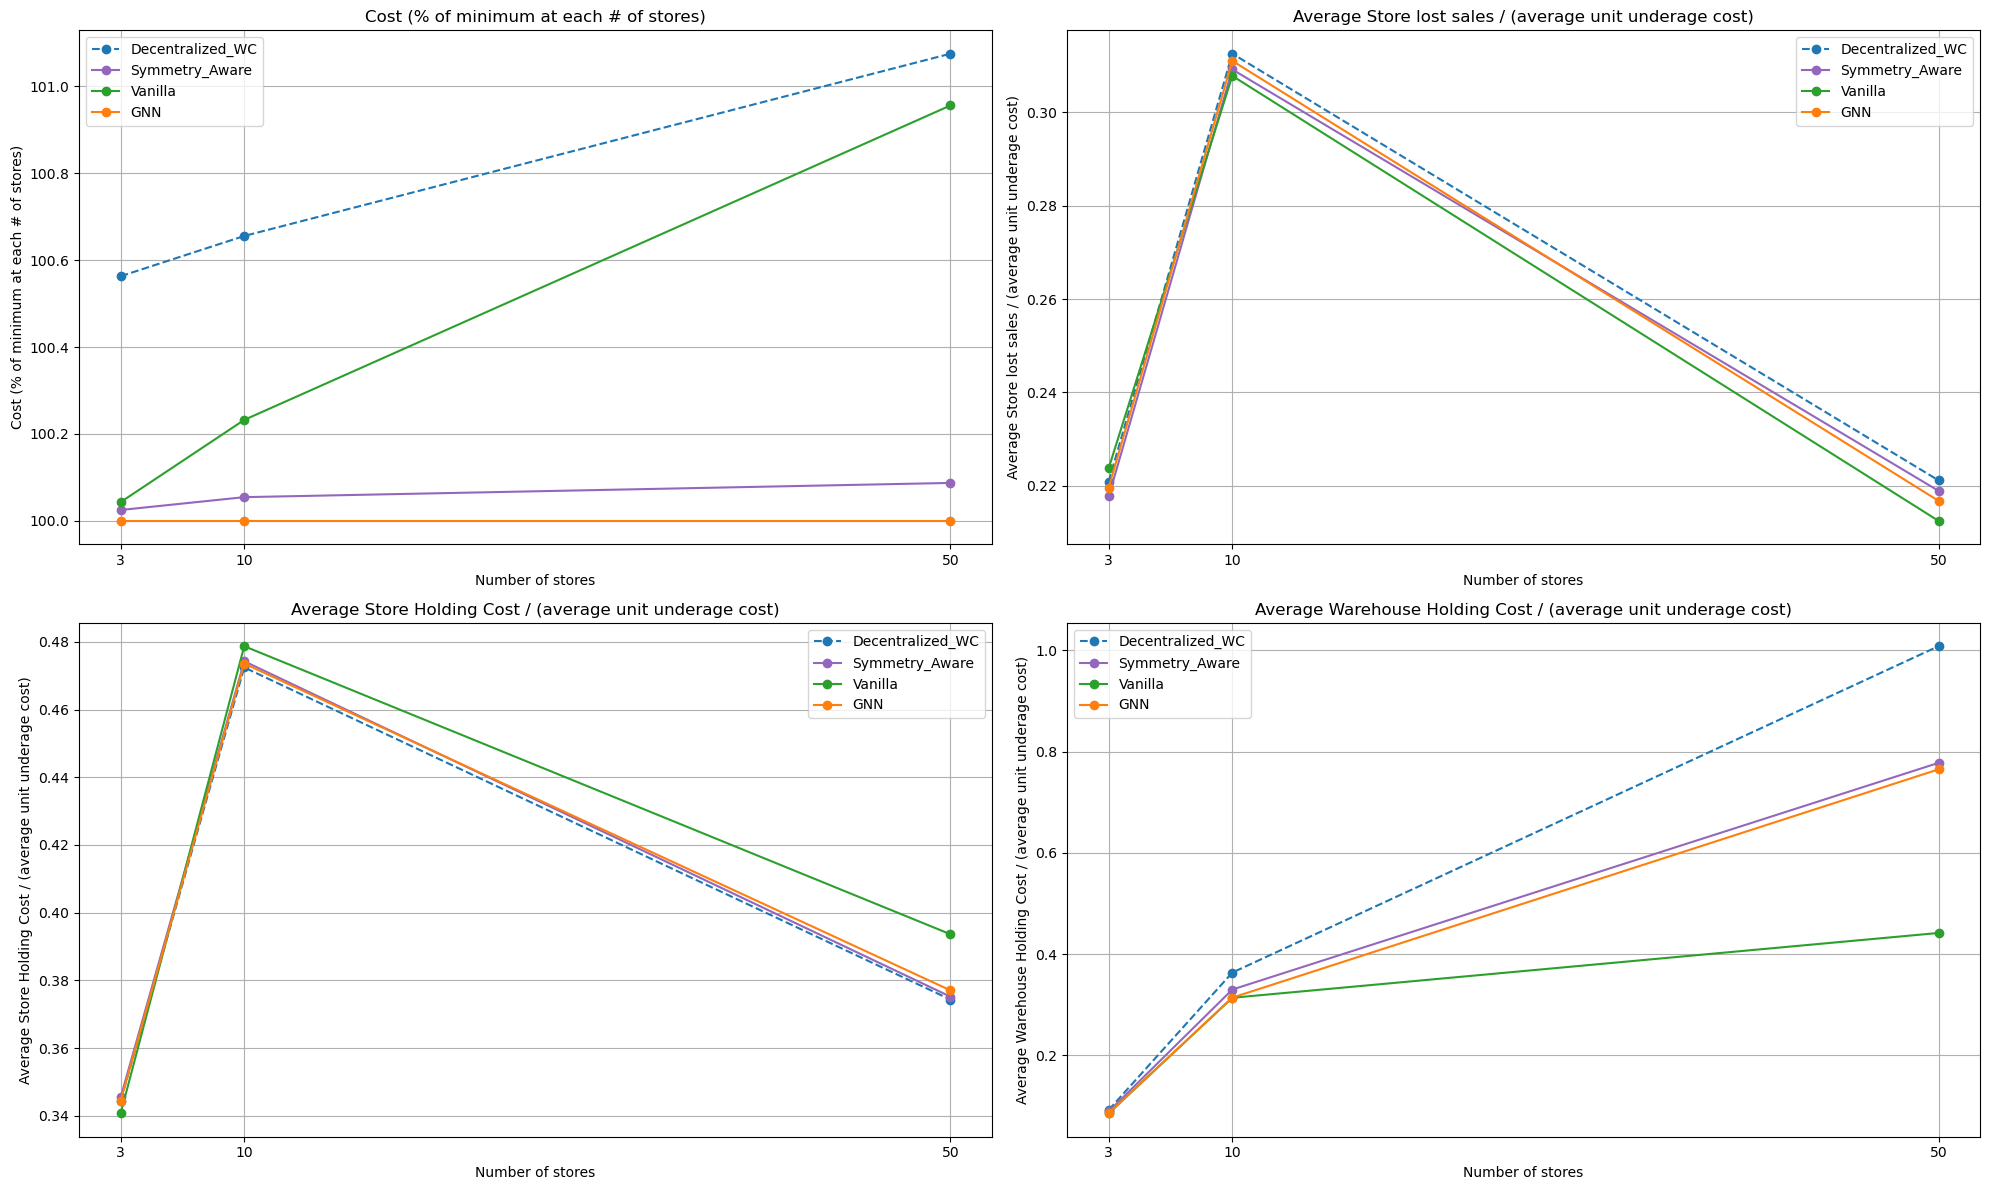

In [4]:
df_t = collect_data_and_plot(df, "test", "one_warehouse_lost_demand_varying_underage_cost_random_yield", 11)